**Содержание:**

1. Задание
2. Импорт библиотек и дополнительные функции
3. Оценка стоимости квартир
4. Оценка зарплаты на базе HeadHunter
5. Выводы

# 1. Задание

**Ultra Lite**

Перепишите ноутбук по предсказанию стоимости квартир. Необходимо создать такую же нейронную сеть, как на лекции. При этом блок с парсингом можно не переписывать.

Можно смотреть в ноутбук с занятия, но код необходимо писать самостоятельно. 

# 2. Импорт библиотек и дополнительные функции

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output
from google.colab import drive
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import random
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Подключаем гугл диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Дополнительные функции: вывода summary и схемы нейронной сети, графика обучения, сохранение истории обучения

In [ ]:
# Функция вывода summary и схемы нейронной сети
def showModel(model):
  #model.summary()
  print ("\n\n")
  return plot_model(model, dpi=80, show_shapes=True)

In [ ]:
# Функция вывода графиков
def chart(hist):
  plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя абсолютная ошибка')
  plt.legend()
  plt.show()

In [ ]:
# Функция для сохранения результата обучения. С последующей записью в таблицу pandas. 
def table(hist):
  dct = []  
  # В цикле проходимся по всем значениям из history                                                  
  for i in hist.history.values():                                        
    dct.append(i)                                            # Результат выгружаются в словарь.                                                                
  result = np.array(dct)                                     # Переводим в numpy массив. 
  return result

# 3. Оценка стоимости квартир

In [ ]:
# Загрузим данные в data frame
df = pd.read_csv('/content/drive/MyDrive/Регрессия база/База квартир/moscow.csv', sep = ';')


In [ ]:
df.head(2)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Выбираем только нечетные строки
df = df.iloc[::2,:]
# Записываем данные в numpy
data = df.values

In [ ]:
df.head(2)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...


In [ ]:
# Посмотрим имена колонок
print(df.columns)

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


## Функции парсинга

In [ ]:
# Максимальное число комнат
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0]  # Получаем число комнат
  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr)
    if (roomsCount > maxRoomCount):
      roomsCount = maxRoomCount
  except: 
    if roomsCountStr == roomsCountStr:  # Проверка на NaN
      if ('Ст' in roomsCountStr):
        roomsCount = maxRoomCount + 1
  return roomsCount

In [ ]:
# Число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount)  # Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount + 2 )  # Превращаем в категорию
  return roomsCount

In [ ]:
# Индекс станции метро
def getMetro(d, allMetroNames):
  metroStr = d[1]
  metro = 0

  if metroStr in allMetroNames:
    metro = allMetroNames.index(metroStr) + 1
  return metro

In [ ]:
# Тип метро
def getMetroType(d):
  metroTypeStr = d[1]
  metroTypeClasses = 5 # Число классов
  metroType = metroTypeClasses - 1  # Изначально последний класс

  # Внутри кольца
  metroNamesInsideCircle = ["Площадь Революции м.", "Арбатская м.", "Смоленская м.", "Красные Ворота м.", "Чистые пруды м.", "Лубянка м.", "Охотный Ряд м.", "Библиотека имени Ленина м.", "Кропоткинская м.", "Сухаревская м.", "Тургеневская м.", "Китай-город м.", "Третьяковская м.", "Трубная м.", "Сретенский бульвар м.", "Цветной бульвар м.", "Чеховская м.", "Боровицкая м.", "Полянка м.", "Маяковская м.", "Тверская м.", "Театральная м.", "Новокузнецкая м.", "Пушкинская м.", "Кузнецкий Мост м.", "Китай-город м.", "Александровский сад м."]
  # На кольце
  metroNamesCircle = ["Киевская м.", "Парк Культуры м.", "Октябрьская м.", "Добрынинская м.", "Павелецкая м.", "Таганская м.", "Курская м.", "Комсомольская м.", "Проспект Мира м.", "Новослободская м.", "Белорусская м.", "Краснопресненская м."]
  # 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская м.", "Электрозаводская м.", "Семёновская м.", "Площадь Ильича м.", "Авиамоторная м.", "Шоссе Энтузиастов м.", "Шелепиха м.", "Римская м.", "Крестьянская Застава м.", "Дубровка м.", "Пролетарская м.", "Волгоградский проспект м.", "Текстильщики м.", "Автозаводская м.", "Технопарк м.", "Коломенская м.", "Тульская м.", "Нагатинская м.", "Нагорная м.", "Шаболовская м.", "Ленинский проспект м.", "Академическая м.", "Фрунзенская м.", "Спортивная м.", "Воробьёвы горы м.", "Студенческая м.", "Кутузовская м.", "Фили м.", "Парк Победы м.", "Выставочная м.", "Международная", "Улица 1905 года м.", "Беговая м.", "Полежаевская м.", "Динамо м.", "Аэропорт м.", "Сокол м.", "Деловой центр м.", "Шелепиха м.", "Хорошёвская м.", "ЦСКА м.", "Петровский парк м.", "Савёловская м.", "Дмитровская м.", "Тимирязевская м.", "Достоевская м.", "Марьина Роща м.", "Бутырская м.", "Фонвизинская м.", "Рижская м.", "Алексеевская м.", "ВДНХ м.", "Красносельская м.", "Сокольники м.", "Преображенская площадь м."]
  # 4-8 станций от кольца
  metroNames48FromCircle = ["Партизанская м.", "Измайловская м.", "Первомайская м.", "Планерная м.", "Щёлковская м.", "Пятницкое шоссе м.", "Новокосино м.", "Новогиреево м.", "Перово м.", "Кузьминки м.", "Рязанский проспект м.", "Выхино м.", "Лермонтовский проспект м.", "Жулебино м.", "Партизанская м.", "Измайловская м.", "Первомайская м.", "Щёлковская м.", "Новокосино м.", "Новогиреево м.", "Перово м.", "Кузьминки м.", "Рязанский проспект м.", "Выхино м.", "Лермонтовский проспект м.", "Жулебино м.", "Улица Дмитриевского м.", "Кожуховская м.", "Печатники м.", "Волжская м.", "Люблино м.", "Братиславская м.", "Коломенская м.", "Каширская м.", "Кантемировская м.", "Царицыно м.", "Орехово м.", "Севастопольская м.", "Чертановская м.", "Южная м.", "Пражская м.", "Варшавская м.", "Профсоюзная м.", "Новые Черёмушки м.", "Калужская м.", "Беляево м.", "Коньково м.", "Университет м.", "Багратионовская м.", "Филёвский парк м.", "Пионерская м.", "Кунцевская м.", "Молодёжная м.", "Октябрьское Поле м.", "Щукинская м.", "Спартак м.", "Тушинская м.", "Сходненская м.", "Войковская м.", "Водный стадион м.", "Речной вокзал м.", "Беломорская м.", "Ховрино м.", "Петровско-Разумовская м.", "Владыкино м.", "Отрадное м.", "Бибирево м.", "Алтуфьево м.", "Фонвизинская м.", "Окружная м.", "Верхние Лихоборы м.", "Селигерская м.", "ВДНХ м.", "Ботанический сад м.", "Свиблово м.", "Бабушкинская м.", "Медведково м.", "Преображенская площадь м.", "Черкизовская м.", "Бульвар Рокоссовского м."]

  # Корректируем категорию 
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  # Превращаем в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType

In [ ]:
# Расстояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0     #Расстояние
  metroDistanceType = 0 #Тип пешком или на транспорте
  
  if (metroDistanceStr == metroDistanceStr):  # Проверка что не NaN
    if (len(metroDistanceStr) > 0):
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1              # Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2              # На транспорте

      metroDistanceStr = metroDistanceStr[:-1]  # Делаем только число
      try:
        #Разделяем на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: # Если в строке не число, то категория 0
        metroDistance = 0
  
  metroDistanceClasses = 7
  
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses 
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses 
    
  # В категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

In [ ]:
# Этаж, этажность, индикатор последнего этажа, тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3]
  except:
    houseStr = ""
  
  houseType = 0   #Тип 
  floor = 0       #Этаж квартиры
  floors = 0      #Этажность
  isLastFloor = 0 #Индикатор последнего этажа
  
  if (houseStr == houseStr): # Проверяем на nan
    if (len(houseStr) > 1):
      try:
        slashIndex = houseStr.index("/") 
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") 
      except:
        print(houseStr)

      # Вытаскиваем строки
      floorStr = houseStr[:slashIndex]              # Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] # Строка этажности дома
      houseTypeStr = houseStr[spaceIndex+1:]        # Строка типа дома
      print('Строка этажа floorStr', floorStr)
      print('Строка этажности дома floorsStr', floorsStr)
      print('Строка типа дома houseTypeStr', houseTypeStr)

      # Выбираем категорию этажа
      try:
        floor = int(floorStr) # В число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        elif (floorSave < 10):
          floor = 3
        elif (floorSave < 20):
          floor = 4
        elif (floorSave >= 20):
          floor = 5
        if (floorSave == 1): # Первый этаж в отдельную категорию
          floor = 1 

        if (int(floorStr) == int(floorsStr)): # Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0  # (отдельная)
      print(' категорию этажа floor', floor)

      # Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) # В число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        elif (floorsSave < 10):
          floors = 2
        elif (floorsSave < 20):
          floors = 3
        elif (floorsSave >= 20):
          floors = 4
      except:
        floors = 0   # отдельная
      print('категорию этажности дома floors', floors)

      # Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    # Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType

In [ ]:
# Тип балкона
def getBalcony(d):
  balconyStr = d[4] 
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  if (balconyStr == balconyStr): # Проверка на nan
    balcony = balconyVariants.index(balconyStr)+1  # Находим индекс
  else:
    balcony = 0 
  balcony = utils.to_categorical(balcony, 16)
  return balcony

In [ ]:
# Тип санузла
def getWC(d):
  wcStr = d[5] 
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  if (wcStr == wcStr):  # Проверка на nan
    wc = wcVariants.index(wcStr)+1 
  else:
    wc = 0 
  wc = utils.to_categorical(wc, 14)
  return wc

In [ ]:
# Площадь
def getArea(d):
  areaStr = d[6] 
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") # Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) # Берём число до разделителя и превращаем в число
    except:
      area = 0 
  else:
    area = 0
  return area

In [ ]:
# Цена
def getCost(d):
  costStr = d[7] 
  try:
    cost = float(costStr) 
  except:
    cost = 0 
  return cost

In [ ]:
# Комментарий
def getComment(d):
  commentStr = d[-1]
  
  return commentStr

In [ ]:
# Объединяем
def getAllParameters(d, allMetroNames):
 
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

In [ ]:
# xTrain
def getXTrain(data):
  
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

# yTrain
def getYTrain(data):
  
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

## Формируем обучающую выборку

In [ ]:
#Делаем маску однокомнатных квартир
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] 
data1 = data[oneRoomMask]
print(data.shape)  # Все примеры
print(data1.shape) # Только однокомнатные

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

Выходные данные были обрезаны до нескольких последних строк (5000).
Строка этажа floorStr 1
Строка этажности дома floorsStr 9
Строка типа дома houseTypeStr П
 категорию этажа floor 1
категорию этажности дома floors 2
Строка этажа floorStr 11
Строка этажности дома floorsStr 16
Строка типа дома houseTypeStr Б
 категорию этажа floor 4
категорию этажности дома floors 3
Строка этажа floorStr 7
Строка этажности дома floorsStr 20
Строка типа дома houseTypeStr М
 категорию этажа floor 3
категорию этажности дома floors 4
Строка этажа floorStr 2
Строка этажности дома floorsStr 6
Строка типа дома houseTypeStr М
 категорию этажа floor 2
категорию этажности дома floors 2
Строка этажа floorStr 11
Строка этажности дома floorsStr 23
Строка типа дома houseTypeStr М
 категорию этажа floor 4
категорию этажности дома floors 4
Строка этажа floorStr 8
Строка этажности дома floorsStr 9
Строка типа дома houseTypeStr П
 категорию этажа floor 3
категорию этажности дома floors 2
Строка этажа floorStr 3
Строка эт

In [ ]:
print(xTrain.shape)

(62504, 109)


##Парсинг текста

In [ ]:
def text2Words(text):
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() 
  words = [] 
  currWord = "" 
  
  for symbol in text:
    if (symbol != "\ufeff"): 
      if (symbol != " "): 
        currWord += symbol 
      else: 
        if (currWord != ""): 
          words.append(currWord)
          currWord = "" 
  if (currWord != ""):
        words.append(currWord)
  return words

def createVocabulary(allWords):
  wCount = dict.fromkeys(allWords, 0)
  for word in allWords:
    wCount[word] += 1 
  wordsList = list(wCount.items())
  wordsList.sort(key = lambda i:i[1], reverse=1)
  sortedWords = [] 
  for word in wordsList:
    sortedWords.append(word[0]) 
  wordIndexes = dict.fromkeys(allWords, 0)
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1
  return wordIndexes

def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  for word in words:
    wordIndex = 0 
    wordInVocabulary = word in vocabulary
    if (wordInVocabulary):
      index = vocabulary[word] 
      if (index < maxWordsCount): 
        wordIndex = index  
    wordsIndexes.append(wordIndex)
  return wordsIndexes

def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  for x in trainVector:
    out[x] = 1 
  return out

def changeSetTo01(trainSet, wordsCount):
  out = []
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) 
  return np.array(out)

def getXTrainComments(data):
  xTrainComments = [] 
  allTextComments = "" 
  for d in data:
    currText = getComment(d) 
    try: 
      if (currText == currText): 
        allTextComments += currText + " " 
    except:
      currText = "Нет комментария" 
    xTrainComments.append(currText) 
  xTrainComments = np.array(xTrainComments)
  return (xTrainComments, allTextComments)

def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] 
  for text in xTrainComments:
    currWords = text2Words(text) 
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) 
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) 
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) 
  return xTrainCommentsIndexes

def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] 
  for text in xTrainComments:
    currWords = text2Words(text) 
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) 
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) 
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen)
  return xTrainCommentsIndexes

## Сбор xTrain по текстам

In [ ]:
xTrainC, allTextComments = getXTrainComments(data1) 
allWords = text2Words(allTextComments) 
allWords = allWords[::10] 
vocabulary = createVocabulary(allWords) 
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


## Нормирование данных

In [ ]:
xScaler = StandardScaler() 
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем 

print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#Нормируем
yScaler = StandardScaler() 
yScaler.fit(yTrain.reshape(-1, 1)) # Обучаем
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) # Нормируем 

# Пример
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


## Проверочная выборка

In [ ]:
splitVal = 0.2 # Процент проверочной выборки
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal # Маска

## callback

In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])                          # Выход на проверочной выборки
  predUnscaled = yScaler.inverse_transform(pred).flatten()                                  #  Обратное нормирование выхода
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()               # Так же для yTrain
  absDelta = abs(predUnscaled - yTrainUnscaled)                                             # Разность по модулю
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)), 3))  # Усредненная ошибка

In [ ]:
# Коллбэк
pltMae = LambdaCallback(on_epoch_end = on_epoch_end)

In [ ]:
# Проверим тип
print(type(xTrainScaled))
print(type(xTrainC01))
print(type(yTrainScaled))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Нейронная сеть

In [ ]:
input1 = Input((xTrainScaled.shape[1],))
input2 = Input(xTrainC01.shape[1],)

x1 = Dense(10, activation='relu')(input1)
x2 = Dense(250, activation='relu')(input2)

x = concatenate([x1,x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

Будем менять шаг обучения 5 раз

### Шаг обучения 1e-3

In [ ]:
model.compile(optimizer=Adam(lr=1e-3), loss='mse')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=50, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]), 
                    verbose=0, callbacks=[pltMae])

Эпоха 0 модуль ошибки 1.788
Эпоха 1 модуль ошибки 2.517
Эпоха 2 модуль ошибки 1.974
Эпоха 3 модуль ошибки 1.806
Эпоха 4 модуль ошибки 1.697
Эпоха 5 модуль ошибки 1.565
Эпоха 6 модуль ошибки 1.278
Эпоха 7 модуль ошибки 5.364
Эпоха 8 модуль ошибки 1.684
Эпоха 9 модуль ошибки 1.237
Эпоха 10 модуль ошибки 1.123
Эпоха 11 модуль ошибки 1.342
Эпоха 12 модуль ошибки 1.416
Эпоха 13 модуль ошибки 1.416
Эпоха 14 модуль ошибки 1.264
Эпоха 15 модуль ошибки 1.191
Эпоха 16 модуль ошибки 1.203
Эпоха 17 модуль ошибки 1.279
Эпоха 18 модуль ошибки 2.552
Эпоха 19 модуль ошибки 1.0
Эпоха 20 модуль ошибки 2.037
Эпоха 21 модуль ошибки 1.016
Эпоха 22 модуль ошибки 1.021
Эпоха 23 модуль ошибки 1.292
Эпоха 24 модуль ошибки 0.979
Эпоха 25 модуль ошибки 1.146
Эпоха 26 модуль ошибки 1.032
Эпоха 27 модуль ошибки 1.22
Эпоха 28 модуль ошибки 1.2
Эпоха 29 модуль ошибки 1.226
Эпоха 30 модуль ошибки 1.01
Эпоха 31 модуль ошибки 1.248
Эпоха 32 модуль ошибки 2.282
Эпоха 33 модуль ошибки 0.933
Эпоха 34 модуль ошибки 1.326
Э

### Шаг обучения 1e-4

In [ ]:
print("---------------------------------------------")
print("Меняем шаг обучения на 1е-4")
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=35,
                     validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]),
                     verbose=0, callbacks=[pltMae])

---------------------------------------------
Меняем шаг обучения на 1е-4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Эпоха 0 модуль ошибки 0.876
Эпоха 1 модуль ошибки 0.906
Эпоха 2 модуль ошибки 0.88
Эпоха 3 модуль ошибки 0.872
Эпоха 4 модуль ошибки 0.893
Эпоха 5 модуль ошибки 0.879
Эпоха 6 модуль ошибки 0.886
Эпоха 7 модуль ошибки 0.866
Эпоха 8 модуль ошибки 0.879
Эпоха 9 модуль ошибки 0.849
Эпоха 10 модуль ошибки 0.884
Эпоха 11 модуль ошибки 0.853
Эпоха 12 модуль ошибки 0.869
Эпоха 13 модуль ошибки 0.846
Эпоха 14 модуль ошибки 0.886
Эпоха 15 модуль ошибки 0.845
Эпоха 16 модуль ошибки 0.868
Эпоха 17 модуль ошибки 0.848
Эпоха 18 модуль ошибки 0.867
Эпоха 19 модуль ошибки 0.841
Эпоха 20 модуль ошибки 0.869
Эпоха 21 модуль ошибки 0.857
Эпоха 22 модуль ошибки 0.874
Эпоха 23 модуль ошибки 0.843
Эпоха 24 модуль ошибки 0.875
Эпоха 25 модуль ошибки 0.841
Эпоха 26 модуль ошибки 0.866
Эпоха 27 модуль ошибки 0.851
Эпоха 28 модуль ошибки 0.863
Эпоха 29 модуль ошибки 0.844
Эпоха 30 модуль ошибки 0.87
Эпоха 31 модуль ошибки 0.87
Эпоха 32 модуль ошибки 0.873
Эпоха 33 модуль ошибки 0.844
Эпоха 34 модуль ошибки 0.86

### Шаг обучения 1e-5

In [ ]:
print("---------------------------------------------")
print("Меняем шаг обучения на 1е-5")
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=35,
                     validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]),
                     verbose=0, callbacks=[pltMae])

---------------------------------------------
Меняем шаг обучения на 1е-5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Эпоха 0 модуль ошибки 0.856
Эпоха 1 модуль ошибки 0.852
Эпоха 2 модуль ошибки 0.849
Эпоха 3 модуль ошибки 0.848
Эпоха 4 модуль ошибки 0.848
Эпоха 5 модуль ошибки 0.847
Эпоха 6 модуль ошибки 0.848
Эпоха 7 модуль ошибки 0.848
Эпоха 8 модуль ошибки 0.848
Эпоха 9 модуль ошибки 0.845
Эпоха 10 модуль ошибки 0.849
Эпоха 11 модуль ошибки 0.846
Эпоха 12 модуль ошибки 0.848
Эпоха 13 модуль ошибки 0.846
Эпоха 14 модуль ошибки 0.849
Эпоха 15 модуль ошибки 0.846
Эпоха 16 модуль ошибки 0.849
Эпоха 17 модуль ошибки 0.846
Эпоха 18 модуль ошибки 0.848
Эпоха 19 модуль ошибки 0.846
Эпоха 20 модуль ошибки 0.849
Эпоха 21 модуль ошибки 0.847
Эпоха 22 модуль ошибки 0.848
Эпоха 23 модуль ошибки 0.849
Эпоха 24 модуль ошибки 0.848
Эпоха 25 модуль ошибки 0.845
Эпоха 26 модуль ошибки 0.85
Эпоха 27 модуль ошибки 0.845
Эпоха 28 модуль ошибки 0.847
Эпоха 29 модуль ошибки 0.845
Эпоха 30 модуль ошибки 0.849
Эпоха 31 модуль ошибки 0.846
Эпоха 32 модуль ошибки 0.848
Эпоха 33 модуль ошибки 0.848
Эпоха 34 модуль ошибки 0.

### Шаг обучения 1e-6

In [ ]:
print("---------------------------------------------")
print("Меняем шаг обучения на 1е-6")
model.compile(optimizer=Adam(lr=1e-6), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=35,
                     validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]),
                     verbose=0, callbacks=[pltMae])

---------------------------------------------
Меняем шаг обучения на 1е-6


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Эпоха 0 модуль ошибки 0.847
Эпоха 1 модуль ошибки 0.847
Эпоха 2 модуль ошибки 0.847
Эпоха 3 модуль ошибки 0.846
Эпоха 4 модуль ошибки 0.847
Эпоха 5 модуль ошибки 0.846
Эпоха 6 модуль ошибки 0.847
Эпоха 7 модуль ошибки 0.847
Эпоха 8 модуль ошибки 0.847
Эпоха 9 модуль ошибки 0.847
Эпоха 10 модуль ошибки 0.846
Эпоха 11 модуль ошибки 0.847
Эпоха 12 модуль ошибки 0.847
Эпоха 13 модуль ошибки 0.846
Эпоха 14 модуль ошибки 0.846
Эпоха 15 модуль ошибки 0.846
Эпоха 16 модуль ошибки 0.846
Эпоха 17 модуль ошибки 0.846
Эпоха 18 модуль ошибки 0.847
Эпоха 19 модуль ошибки 0.846
Эпоха 20 модуль ошибки 0.846
Эпоха 21 модуль ошибки 0.846
Эпоха 22 модуль ошибки 0.847
Эпоха 23 модуль ошибки 0.846
Эпоха 24 модуль ошибки 0.846
Эпоха 25 модуль ошибки 0.846
Эпоха 26 модуль ошибки 0.847
Эпоха 27 модуль ошибки 0.846
Эпоха 28 модуль ошибки 0.846
Эпоха 29 модуль ошибки 0.846
Эпоха 30 модуль ошибки 0.846
Эпоха 31 модуль ошибки 0.846
Эпоха 32 модуль ошибки 0.847
Эпоха 33 модуль ошибки 0.846
Эпоха 34 модуль ошибки 0

### Шаг обучения 1e-7

In [ ]:
print("---------------------------------------------")
print("Меняем шаг обучения на 1е-7")
model.compile(optimizer=Adam(lr=1e-7), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=35,
                     validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]),
                     verbose=0, callbacks=[pltMae])

---------------------------------------------
Меняем шаг обучения на 1е-7


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Эпоха 0 модуль ошибки 0.846
Эпоха 1 модуль ошибки 0.846
Эпоха 2 модуль ошибки 0.846
Эпоха 3 модуль ошибки 0.846
Эпоха 4 модуль ошибки 0.846
Эпоха 5 модуль ошибки 0.846
Эпоха 6 модуль ошибки 0.846
Эпоха 7 модуль ошибки 0.846
Эпоха 8 модуль ошибки 0.846
Эпоха 9 модуль ошибки 0.846
Эпоха 10 модуль ошибки 0.846
Эпоха 11 модуль ошибки 0.846
Эпоха 12 модуль ошибки 0.846
Эпоха 13 модуль ошибки 0.846
Эпоха 14 модуль ошибки 0.846
Эпоха 15 модуль ошибки 0.846
Эпоха 16 модуль ошибки 0.846
Эпоха 17 модуль ошибки 0.846
Эпоха 18 модуль ошибки 0.846
Эпоха 19 модуль ошибки 0.846
Эпоха 20 модуль ошибки 0.846
Эпоха 21 модуль ошибки 0.846
Эпоха 22 модуль ошибки 0.846
Эпоха 23 модуль ошибки 0.846
Эпоха 24 модуль ошибки 0.846
Эпоха 25 модуль ошибки 0.846
Эпоха 26 модуль ошибки 0.846
Эпоха 27 модуль ошибки 0.846
Эпоха 28 модуль ошибки 0.846
Эпоха 29 модуль ошибки 0.846
Эпоха 30 модуль ошибки 0.846
Эпоха 31 модуль ошибки 0.846
Эпоха 32 модуль ошибки 0.846
Эпоха 33 модуль ошибки 0.846
Эпоха 34 модуль ошибки 0

### Проверка результатов

In [ ]:
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])                # Выход на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten()                       # Обратное нормирование выхода сети
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()    # Обратное нормирование для yTrain
absDelta = abs(predUnscaled - yTrainUnscaled)                                  # Разность по модулю 
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta)))  # Усредненная ошибка


Модуль ошибки 0.8462991431350998


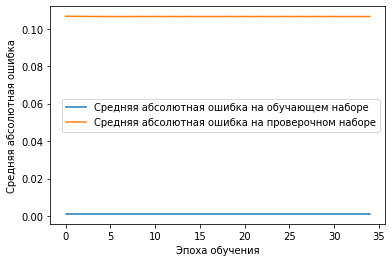

In [ ]:
# График ошибки
plt.plot(history.history['loss'], label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Это график только последнего обучения, ошибка практически не менялась.

Количество эпох было уменьшено с 200 до 35, так как происходило переполнение памяти. Если сохранять лучшие веса после каждого обучения, перед изменением шага lr, и увеличивать кол-во эпох, то можно добиться лучшего результата.  

                                                          **Еще одна переписанная задача**

# 4. Оценка зарплаты на базе HeadHunter

In [ ]:
# Подгружаем базу
fixed_df =pd.read_csv('/content/drive/MyDrive/Регрессия база/База резюме/hh_fixed.csv')

In [ ]:
# Посмотрим кол-во (резюме и критериев)
print(fixed_df.shape)

(62967, 13)


In [ ]:
# Первые 3 строки
fixed_df.head(3)

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано


In [ ]:
# Так же посмотрим пример каждого резюме
n = 100  # Номер резюме
for i in range(len(fixed_df.values[n])):
  print(i, "-", fixed_df.values[n][i])

0 - 100
1 - Мужчина ,  27 лет , родился 25 июня 1991
2 - 45000 руб.
3 - Техническая поддержки, Помощник системного администратора
4 - Москва ,  м. Молодежная , не готов к переезду , готов к редким командировкам
5 - полная занятость
6 - полный день
7 - Опыт работы 4 года 1 месяц  Октябрь 2017 — Декабрь  2017 3 месяца ООО "Сателл ИТ" Москва первая линия технической поддержки Помощь клиентам по системе ДБО  Июль 2016 — Ноябрь  2016 5 месяцев РОНИКОН, фабрика шкафов Москва , www.ronikon.ru Розничная торговля ... Розничная сеть (мебель) Товары народного потребления (непищевые) Мебель (продвижение, оптовая торговля) Мебель (производство) Оператор технической поддержки Приём и обработка звонков и заявок, так же удалённая помощь пользователям и в пределах офиса, отслеживание заявок в hekpdesk формирование отчётов.  Июнь 2015 — Февраль  2016 9 месяцев АО "ФЦНИВТ "СНПО "ЭЛЕРОН" Москва , www.eleron.ru техник Сборка компьютеров, настройка и заливка программного обеспечения Windows от XP до Server 

## Парсинг базы

In [ ]:
# Убираем первый столбец с индексами
fixed_df = fixed_df.drop(fixed_df.columns[0], axis = 1)

In [ ]:
# Убираем кодировку \xa0 и \n в описаниях
for j in range(12): # Для каждого из столбцов
  for i in range(fixed_df.shape[0]):
    if type(fixed_df.values[i][j]) != float:  #Если данные текстовые
      fixed_df.values[i][j] = fixed_df.values[i][j].replace('\xa0','')
      fixed_df.values[i][j] = fixed_df.values[i][j].replace('\n','')

In [ ]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  if 'M' in arg:
    out[0] = 1
  year_tec = 2021 # Текущий год
  if len(arg) > 7:
    out[1] = year_tec - int(re.findall(r'\d{4}' ,fixed_df.values[0][0])[0])
  return out

In [ ]:
# Превращаем полученный возраст в класс категории
def getParameterAgeVect(arg):
  outClass =int((arg - 13) / 5)
  outClass = max(0, min(10, outClass))
  return list(utils.to_categorical(outClass, 11). astype('int')) #На выходе вектор с нужной категорией

In [ ]:
# Зарплата
def getParameterSalary(arg):
  num = arg
  # Убираем лишние знаки, чтобы получить число
  if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')

    # Получаем валюту, убираем цифры
  curr = re.sub('[0-9]','',arg)
  curr = curr.replace('.','').strip()

    # Если валюта конвертируем в рубли
  if curr == 'USD' or curr == 'usd':
    num = float(num) * 71.7
  elif curr == 'KZT' or curr == 'kzt':
    num = float(num) * 0.17
  elif curr == 'ГРН' or curr == 'грн' or curr == 'UAH' or curr == 'uah':
     num = float(num) * 2.65
  elif curr == 'БЕЛРУБ' or curr == 'белруб' or curr == 'BYN' or curr == 'byn':
    num = float(num) * 28.9
  elif curr == 'EUR' or curr == 'eur':
    num = float(num) * 87.3
  elif curr == 'KGS' or curr == 'kgs':
    num = float(num) * 0.85
  elif curr == 'СУМ' or curr == 'сум' or curr == 'UZS' or curr == 'uzs':
    num = float(num) * 0.068
  elif curr == 'AZN' or curr == 'azn' or curr == 'намат' or curr == 'НАМАТ':
    num = float(num) * 42.2
    
  salaryStr = int(num)
  return salaryStr

In [ ]:
# Данные о городе
def getParameterCity(arg):
  millionCities = 'Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград'
  sarg = arg.split(',')
  for i in sarg:
    i = i.strip()
    if i == 'Москва':
      return [1, 0, 0, 0]
    if i == 'Санкт-Петербург' or i == 'Питер':
      return [0, 1, 0, 0]
    if i in millionCities:
      return [0, 0, 1, 0]
    return [0, 0, 0, 1] 

In [ ]:
# Желаемая занятость
def getParameterEmployment(arg):
  out = [0, 0, 0, 0]
  if ('Cтажировка' in arg)  or ('стажировка' in arg):
    out[0] = 1
  if ('Частичная занятость' in arg) or ('частичная занятость' in arg):
    out[1] = 1
  if ('Проектная работа' in arg) or ('проектная работа' in arg):
    out[2] = 1
  if ('Полная занятость' in arg) or ('полная занятость' in arg):
    out[3] = 1
  return out

In [ ]:
# Желаемый график работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ('Гибкий график' in arg) or ('гибкий график' in arg):
    out[0] = 1
  if ('Полный день' in arg) or ('полный день' in arg):
    out[1] = 1
  if ('Сменный график' in arg) or ('Сменный график' in arg):
    out[2] = 1
  if ('Удаленная работа' in arg) or ('удаленная работа' in arg) or ('удалённая работа' in arg):
    out[3] = 1  
  return out

In [ ]:
# Образование
def getParameterEducation(arg):
  out = [0, 0, 0, 0]
  if ('Высшее Higher education' in arg) or ('высшее Higher education' in arg) or ('Higher education' in arg) or ('Высшее образование' in arg) or ('высшее образование' in arg):
    out[0] = 1
  if ('Среднее специальное' in arg) or ('среднее специальное' in arg):
    out[1] = 1
  if ('Неоконченное высшее' in arg) or ('неоконченное высшее' in arg):
    out[2] = 1
  if ('Среднее образование' in arg) or ('среднее образование' in arg):
    out[3] = 1  
  return out

In [ ]:
# Опыт работы
def getParameterExperience(arg):
  arg = str(arg)
  # Проверяем что данная строка не пустая
  symbols, years, months = 0, 0, 0
  for s in arg:
    if (s != " "):
      symbols += 1
  
  # Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1
    
      #years = 0
      #months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
        if (len(spacesIndexes) >= 3):
          yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]]  # Лет
          years = int(yearsStr)
      
        if (len(spacesIndexes) >= 5):
          monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Месяцев
          if (arg[spacesIndexes[4]+1] == "м"):
            try:
              months = int(monthsStr)
            except: 
              months = 0
      else:   
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)
      
  return 12*years + months

In [ ]:
# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): 
    outClass = 1
  if out > 12:  outClass = 2
  if out > 24:  outClass = 3
  if out > 36:  outClass = 4
  if out > 60:  outClass = 6
  if out > 96:  outClass = 6
  if out > 120: outClass = 7
  if out > 156: outClass = 8
  if out > 192: outClass = 9
  if out > 240: outClass = 10

  return list(utils.to_categorical(outClass,11).astype('int'))

In [ ]:
# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]                                   # Пол
  age =getParameterAgeVect(result[1])               # Возраст
  city = getParameterCity(val[3])                   # Город
  employment = getParameterEmployment(val[4])       # Занятость
  shedule = getParameterSchedule(val[5])            # График
  education = getParameterEducation(val[9])         # Образование
  experience = getParameterExperienceVector(val[6]) # Опыте
  out = []

  # Соединяем все параметры в вектор
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience
  
  return out

In [ ]:
# Создание тренировочной выборки
def get01Data(values):
  xTrain = []
  yTrain = []

  # Будем предсказывать зарплату
  for val in values:
    y = getParameterSalary(val[1])

   # Записываем в обучающую выборку все кроме зарплаты
    if (y != -1):
      x = getAllParameters(val)
      xTrain.append(x)
      yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  return (xTrain, yTrain)

In [ ]:
# Извлекаем значения
(xTrain01, yTrain) = get01Data(fixed_df.values)

In [ ]:
# Посмотрим какие получилась выборка
print(xTrain01.shape)
print(yTrain.shape)

(62967, 39)
(62967,)


In [ ]:
# И любой из примеров
print(f'Массив состоит из {len(xTrain01[50000])} значений')
print(xTrain01[50000])
print(yTrain[50000])

Массив состоит из 39 значений
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0]
60.0


## Нейронная сеть по простым данным

In [ ]:
# Создадим таблицу
HeadHunter_df = pd.DataFrame(columns = ['loss(min)', 'mae(min)', 'val_loss(min)', 'val_mae(min)'])

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1000, activation = 'tanh'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Схема модели

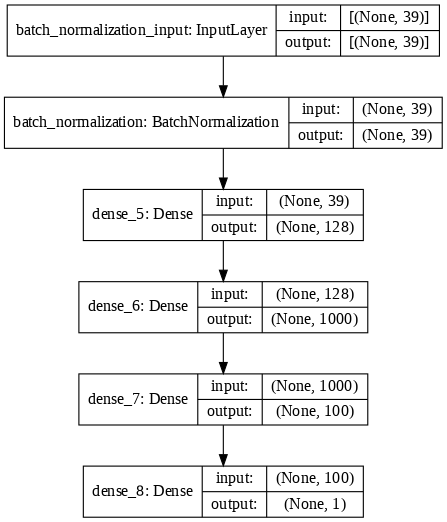

In [ ]:
showModel(model)

### Обучение

In [ ]:
history = model.fit(xTrain01, yTrain, epochs=50, batch_size=32, validation_split=0.15, verbose=2)

Epoch 1/50
1673/1673 - 5s - loss: 19052.5605 - mae: 38.1196 - val_loss: 2881.8635 - val_mae: 35.0179
Epoch 2/50
1673/1673 - 4s - loss: 18486.5820 - mae: 34.7179 - val_loss: 2900.3789 - val_mae: 35.9284
Epoch 3/50
1673/1673 - 4s - loss: 18439.6855 - mae: 34.5065 - val_loss: 2844.5112 - val_mae: 34.8684
Epoch 4/50
1673/1673 - 4s - loss: 18440.6680 - mae: 34.2975 - val_loss: 2857.5203 - val_mae: 35.6701
Epoch 5/50
1673/1673 - 4s - loss: 18421.3594 - mae: 34.0805 - val_loss: 2877.6038 - val_mae: 36.5236
Epoch 6/50
1673/1673 - 4s - loss: 18422.1484 - mae: 34.4089 - val_loss: 2870.3669 - val_mae: 35.5667
Epoch 7/50
1673/1673 - 4s - loss: 18418.9219 - mae: 34.1918 - val_loss: 2864.7388 - val_mae: 35.1534
Epoch 8/50
1673/1673 - 4s - loss: 18407.9961 - mae: 34.2601 - val_loss: 2839.9419 - val_mae: 35.2518
Epoch 9/50
1673/1673 - 4s - loss: 18411.1172 - mae: 34.1138 - val_loss: 2843.1746 - val_mae: 35.1987
Epoch 10/50
1673/1673 - 4s - loss: 18401.2109 - mae: 34.0519 - val_loss: 2882.6658 - val_ma

### График 








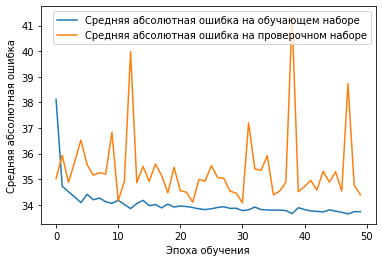

In [ ]:
chart(history)

In [ ]:
# Делаем предсказание модели 
pred = model.predict(xTrain01)
pred = pred.flatten()
# Среднее значение ошибки
absDelta = abs(pred - yTrain)
print(sum(absDelta / len(absDelta)))

33.46646299491447


## Нейронная сеть по простым нормированным данным

In [ ]:
# Нормализуем данные
yScaler = StandardScaler()
yScaler.fit(yTrain.reshape(-1,1))
yTrainScaler = yScaler.transform(yTrain.reshape(-1,1))

print(yTrainScaler.shape)
print(yTrain[1])           # Оригинальное значение
print(yTrainScaler[1])     # Нормированное

(62967, 1)
40.0
[-0.28400349]


In [ ]:
print (min(yTrain), max(yTrain))                 # max и min значения в yTrain
print (min(yTrainScaler), max(yTrainScaler))     # max и min значения в в нормированном yTrain

0.001 27246.0
[-0.5868129] [205.67696256]


In [ ]:
# Та же самая архитектура сети
modelS = Sequential()
modelS.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
modelS.add(Dense(128, activation='relu'))
modelS.add(Dense(1000, activation='tanh'))
modelS.add(Dense(100, activation='relu'))
modelS.add(Dense(1, activation='linear'))

modelS.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Обучение

In [ ]:
history = modelS.fit(xTrain01, yTrainScaler, epochs=50, batch_size=32, validation_split=0.15, verbose=2)

Epoch 1/50
1673/1673 - 5s - loss: 1.0605 - mae: 0.2648 - val_loss: 0.1650 - val_mae: 0.2665
Epoch 2/50
1673/1673 - 4s - loss: 1.0581 - mae: 0.2615 - val_loss: 0.1650 - val_mae: 0.2589
Epoch 3/50
1673/1673 - 4s - loss: 1.0560 - mae: 0.2589 - val_loss: 0.1654 - val_mae: 0.2619
Epoch 4/50
1673/1673 - 4s - loss: 1.0554 - mae: 0.2585 - val_loss: 0.1649 - val_mae: 0.2690
Epoch 5/50
1673/1673 - 4s - loss: 1.0545 - mae: 0.2584 - val_loss: 0.1655 - val_mae: 0.2667
Epoch 6/50
1673/1673 - 4s - loss: 1.0550 - mae: 0.2562 - val_loss: 0.1682 - val_mae: 0.2746
Epoch 7/50
1673/1673 - 4s - loss: 1.0531 - mae: 0.2582 - val_loss: 0.1641 - val_mae: 0.2701
Epoch 8/50
1673/1673 - 4s - loss: 1.0551 - mae: 0.2584 - val_loss: 0.1622 - val_mae: 0.2633
Epoch 9/50
1673/1673 - 4s - loss: 1.0536 - mae: 0.2565 - val_loss: 0.1632 - val_mae: 0.2619
Epoch 10/50
1673/1673 - 4s - loss: 1.0537 - mae: 0.2567 - val_loss: 0.1654 - val_mae: 0.2646
Epoch 11/50
1673/1673 - 4s - loss: 1.0537 - mae: 0.2559 - val_loss: 0.1647 - va

### График 








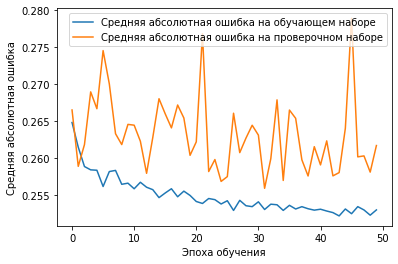

In [ ]:
chart(history)

In [ ]:
# Делаем предсказание модели 
pred = modelS.predict(xTrain01)
pred = pred.flatten()
# Среднее значение ошибки
absDelta = abs(pred - yTrain)
print(sum(absDelta / len(absDelta)))

77.50830239268667


### Оценка результатов

In [ ]:
yy = model.predict(xTrain01)

n = 10 # Кол-во результатов
for i in range(n):
  print('Реальное значение - ', yTrain[i], 'Предсказанное значение - ', yy[i][0], 'Разница - ', abs(yTrain[i] - yy[i][0]))

Реальное значение -  40.0 Предсказанное значение -  42.822987 Разница -  2.822986602783203
Реальное значение -  40.0 Предсказанное значение -  60.56284 Разница -  20.56283950805664
Реальное значение -  300.0 Предсказанное значение -  137.76463 Разница -  162.23536682128906
Реальное значение -  180.0 Предсказанное значение -  132.2344 Разница -  47.765594482421875
Реальное значение -  40.0 Предсказанное значение -  47.573193 Разница -  7.573192596435547
Реальное значение -  200.0 Предсказанное значение -  137.76463 Разница -  62.23536682128906
Реальное значение -  120.0 Предсказанное значение -  79.127396 Разница -  40.87260437011719
Реальное значение -  50.0 Предсказанное значение -  86.31283 Разница -  36.312828063964844
Реальное значение -  60.0 Предсказанное значение -  64.41669 Разница -  4.41668701171875
Реальное значение -  70.0 Предсказанное значение -  117.17087 Разница -  47.170867919921875


# 5. Выводы:

1. Весь ноутбук переписывался в ручную что является хорошей практикой

2. Задачи Цены на квартиры и вакансии

3. Было переписаны не только нейронные сети, но и все функции парсинга и нашел несколько ошибок. Так как каждую функцию разбирал по шагам. 

  3.1  Функция этажа: 
   Выбираем категорию этажа
      try:
        floor = int(floorStr) # В число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        elif (floorSave < 10):
          floor = 3
        elif (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): # Первый этаж в отдельную категорию
          floor = 1 
        

  Нужно вместо if написать elif иначе все попадали в 4 категорию если этаж меньше 20

       Так же и категория этажности дома, если этажей меньше 20, все попадают в 3 категорию. И нужно точно таже вместо конструкции if использовать elif.
 
    3.2 База HeadHunter
       
       3.2.1. Исправил ошибку в функции Данные об опыте работы, не считала месяцы

        monthsStr = arg[spacesIndexes[3] : spacesIndexes[4]] # Строка месяцев
        if (arg[spacesIndexes[2] + 1] == 'м'):
          months = int(monthsStr)

        monthsStr = arg[spacesIndexes[3] : spacesIndexes[4]] # Строка месяцев
        if (arg[spacesIndexes[4] + 1] == 'м'):
          months = int(monthsStr)

        В переменную которая считает месяцы monthsStr не записывало кол-во. Так как не верно выбирал spacesIndexes[4] было spacesIndexes[2] из-за этого не находил букву 'м'. 

       3.2.2. Не правильно определяет категорию метро, всегда 4 категория, не зависимо какая станция. Внутри кольца или на кольце. Все потому что сравнивается входит ли строчка "Маяковская м." в строку "Маяковская". И поэтому всегда False. Потому что во всем столбце название метро идет с префексом "м.".
   Пришлось переписать названия всех станций и после этого стало определять категорию верно
Добавил станции метро Шелепиха, Пятницкое шоссе. Не определял в нужную категорию


